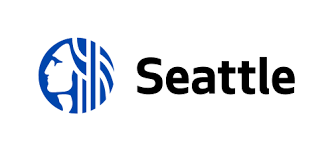

### Anticiper les besoins en consommation de bâtiments - Prédiction de la consommation totale d'énergie

### Sommaire


* [1. Importation des librairies, définition des fonctions et importation du fichier](#1)
    * [1.1 Importation des librairies](#1_1)
    * [1.2 Définition des fonctions](#1_2)
    * [1.3 Importation du fichier](#1_3)
* [2. Preprocessing](#2)
    * [2.1 Matrice X des données et vecteur y des cibles](#2_1)
    * [2.2 Division en train set et test set](#2_2)
* [3. Modelisation](#3)
    * [3.1 Dummy regressor (Baseline)](#3_1)
    * [3.2 Régression linéaire](#3_2)
    * [3.3 Régression ridge](#3_3)
    * [3.4 Lasso](#3_4)
    * [3.5 Elastic net](#3_5)
    * [3.6 Linear SVR](#3_6)
    * [3.7 Forêts aléatoires](#3_7)
    * [3.8  XGBoost](#3_8)
* [4. Choix du modèle](#4)
    * [4.1  Affichage des scores](#4_1)
    * [4.2 Comparaison des scores obtenus](#4_2)
    * [4.3  Comparaison par le coefficient de détermination](#4_3)
    * [4.4  Comparaison par l'erreur](#4_4)
    * [4.5  Comparaison par le temps d'exécution](#4_5)
    * [4.6 Courbe d'apprentissage sur le XGBoost](#4_6)
* [5. Evaluation de l'intérêt de l'ENERGY STAR score pour la prédiction](#5)
    * [5.1 Preprocessing](#5_1)
    * [5.2 Modélisation du XGBoost avec l'ENERGY STAR score](#5_2)
    * [5.3 Comparaison des scores avec ou sans ENERGY STAR score](#5_3)
* [6. Importance des caractéristiques (Features importance)](#6)
* [7. Enregistrement du modèle](#7)

## 1. Importation des librairies, définition des fonctions et importation du fichier <a class="anchor" id="1"></a>

### 1.1 Importation des librairies <a class="anchor" id="1_1"></a>

In [1]:
# data
import pandas as pd
import numpy as np
from numpy import log1p, exp

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Temps d'exécution
import time

# Sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

# XGBoost
from xgboost import XGBRegressor

# Interprétabilité
import shap
shap.initjs() # Initialisation du Javascript

# Améliorer le temps d'exécution
from joblib import parallel_backend

# Pour le stockage du modèle
import pickle

### 1.2 Définition des fonctions <a class="anchor" id="1_2"></a>

In [2]:
def final_pipeline(X, model, params):
    variables_quantitatives = X.select_dtypes(['int64','float64']).columns.to_list()
    variables_qualitatives = X.select_dtypes(['object','bool']).columns.to_list()
    quantitatif_scaler = StandardScaler()
    qualitatif_encoder = OneHotEncoder(handle_unknown='ignore')
    transformers = [('qualitatif', qualitatif_encoder, variables_qualitatives), 
                    ('quantitatif', quantitatif_scaler, variables_quantitatives)]
    preparation = ColumnTransformer(transformers)
    model_pipeline = make_pipeline(preparation, model) 
    grid = GridSearchCV(model_pipeline, 
                        params, 
                        cv=5, 
                        scoring='r2', 
                        n_jobs=-1)
    
    return grid

def bestParams(model):
    """Afficher les meilleurs paramètres, et le meilleur score"""
    best_params = model.best_params_
    print('Les meilleurs paramètres sont :')
    print(best_params)

def affichage_résultats(model):
    """Dataframe présentant les résultats du modèle"""
    # Résultats de la recherche sur grille
    résultats = pd.DataFrame(model.cv_results_)
    colonnes = [i for i in résultats.columns if 'split' not in i]
    #résultats = résultats[['mean_score_time', 'params', 'mean_test_score', 'rank_test_score']]
    résultats = résultats[colonnes]
    
    # Trier les résultats en fonction du classement du test
    résultats = résultats.sort_values('rank_test_score')
    
    return résultats.head(10)

# Créer un DataFrame vide pour stocker les résultats
df_results = pd.DataFrame(columns=['Model', 'R2_train', 'R2_test', 'MAE_test', 'RMSE_test', "Temps d'exécution"])

def score(model, X_train, y_train, X_test, y_test, model_name, execution_time, df_results):
    """Fonction pour calculer et ajouter les scores R2, MAE et RMSE dans le DataFrame"""
    y_train_pred = model.predict(X_train)  # Prédictions sur l'ensemble d'entraînement
    y_test_pred = model.predict(X_test)    # Prédictions sur l'ensemble de test
    
    R2_train = round(metrics.r2_score(y_train, y_train_pred), 2)
    R2_test = round(metrics.r2_score(y_test, y_test_pred), 2)
    
    # Appliquer np.exp aux prédictions de l'ensemble de test
    y_test_pred = np.exp(y_test_pred)
    
    MAE_test = round(metrics.mean_absolute_error(np.exp(y_test), y_test_pred), 2)
    MSE_test = round(metrics.mean_squared_error(np.exp(y_test), y_test_pred), 2)
    RMSE_test = round(np.sqrt(MSE_test), 2)
    
    # Ajouter les résultats du modèle au DataFrame global en supprimant les potentiels doublons
    df_results.loc[df_results.shape[0]] = [model_name, R2_train, R2_test, MAE_test, RMSE_test, execution_time]
    df_results = df_results.drop_duplicates(subset=['Model'])

    return df_results
    
def visualisation_erreur(y_pred_train, y_train, y_pred_test, y_test):
    """Fonction pour afficher un scatter plot pour visualiser les erreurs de prédictions
    du train set et du test set"""
    plt.figure(figsize=(5,8))

    plt.subplot(2,1,1)
    plt.title("Visualisation de l'erreur des prédictions sur le train set", fontweight='bold')
    plt.scatter(np.exp(y_pred_train), np.exp(y_train))  # Convertir en l'exponentiel
    y_min, y_max = np.exp(min(y_train)), np.exp(max(y_train))
    plt.plot([y_min, y_max], [y_min, y_max], color='red')
    plt.xlabel('Valeurs prédites')
    plt.ylabel('Valeurs cibles')
    
    plt.subplot(2,1,2)
    plt.title("Visualisation de l'erreur des prédictions sur le test set", fontweight='bold')
    plt.scatter(np.exp(y_pred_test), np.exp(y_test))  # Convertir en l'exponentiel
    y_min, y_max = np.exp(min(y_test)), np.exp(max(y_test))
    plt.plot([y_min, y_max], [y_min, y_max], color='red')
    plt.xlabel('Valeurs prédites')
    plt.ylabel('Valeurs cibles')

    # Ajuster l'espacement entre les sous-graphiques
    plt.tight_layout()

    plt.show()

### 1.3 Importation du fichier <a class="anchor" id="1_3"></a>

In [3]:
df = pd.read_csv('df_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475 entries, 0 to 1474
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PrimaryPropertyType              1475 non-null   object 
 1   Neighborhood                     1475 non-null   object 
 2   NumberofBuildings                1475 non-null   float64
 3   NumberofFloors                   1475 non-null   int64  
 4   PropertyGFATotal                 1475 non-null   int64  
 5   PropertyGFAParking               1475 non-null   int64  
 6   LargestPropertyUseType           1475 non-null   object 
 7   LargestPropertyUseTypeGFA        1475 non-null   float64
 8   SecondLargestPropertyUseType     1475 non-null   object 
 9   SecondLargestPropertyUseTypeGFA  1475 non-null   float64
 10  ThirdLargestPropertyUseType      1475 non-null   object 
 11  ThirdLargestPropertyUseTypeGFA   1475 non-null   float64
 12  ENERGYSTARScore     

## 2. Preprocessing <a class="anchor" id="2"></a>

### 2.1 Matrice X des données et vecteur y des cibles <a class="anchor" id="2_1"></a>

In [4]:
# Instancier X et y
X = df.drop(['ENERGYSTARScore', 'TARGET_SiteEnergyUse(kBtu)', 'TARGET_TotalGHGEmissions'], axis=1)
y = df['TARGET_SiteEnergyUse(kBtu)']

# Mettre y au log
log_transformer = FunctionTransformer(func=np.log, inverse_func=np.exp)
y_log = log_transformer.transform(y)

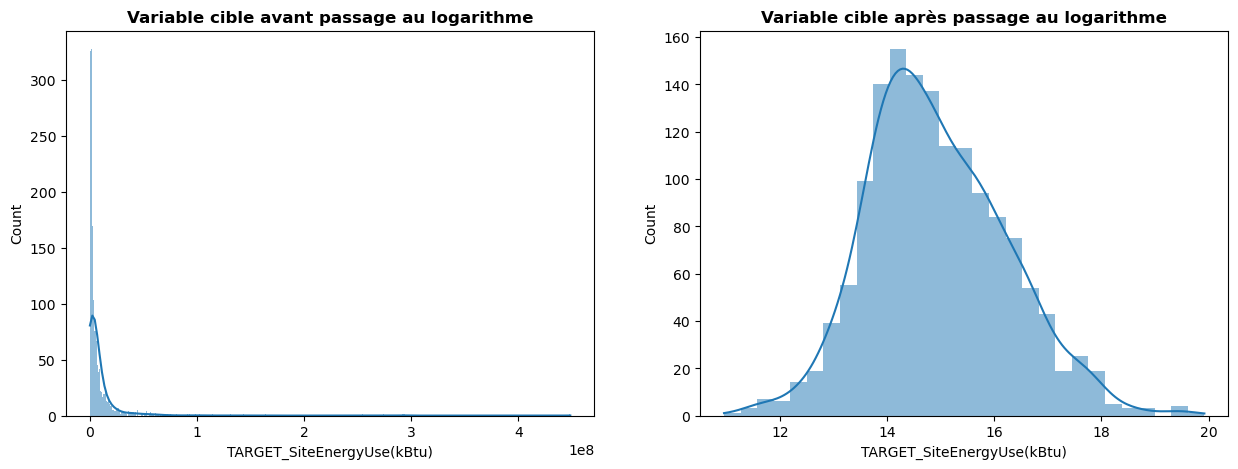

In [5]:
# Visualisation du preprocessing sur la variable cible
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(y, kde=True, edgecolor='none')
plt.title("Variable cible avant passage au logarithme", fontweight='bold')
plt.subplot(1,2,2)
sns.histplot(y_log, kde=True, edgecolor='none')
plt.title("Variable cible après passage au logarithme", fontweight='bold')
plt.show()

### 2.2 Division en train set et test set <a class="anchor" id="2_2"></a>

In [6]:
# On divise notre train set et test set
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, train_size=0.8, random_state=0)

# Vérifions la taille de notre train set et de notre test set
print(f'Nous avons X_train de forme {X_train.shape} et y_train_log de forme {y_train_log.shape}.')
print()
print(f'Nous avons X_test de forme {X_test.shape} et y_test_log de forme {y_test_log.shape}.')

Nous avons X_train de forme (1180, 16) et y_train_log de forme (1180,).

Nous avons X_test de forme (295, 16) et y_test_log de forme (295,).


## 3. Modelisation <a class="anchor" id="3"></a>

### 3.1 Dummy regressor (Baseline) <a class="anchor" id="3_1"></a>

In [7]:
# Créer un dictionnaire de paramètres pour la GridSearchCV
params = {
    'dummyregressor__strategy': ['mean', 'median']
}

# utilisation de la fonction 'final_pipeline'
dummy_regressor = final_pipeline(X, DummyRegressor(), params)

# Entraînement du modèle
dummy_regressor.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'LargestPropertyUseTypeGFA',
                                                                          'SecondLargestPropertyUseTypeGFA',
                                                                          'ThirdLargestPropertyUseTypeGFA',
                                                                          'EraBuild',
                                                                          'SteamUse_Ratio',
                                                                          'ElectricityUse_Ratio',
                                                                          'NaturalGasUse_Ratio'])])),
                                       ('dummyregressor', DummyRegressor())]),
             n_jobs=-1,
             param_grid={'dummyregressor__strategy': ['mean', 'median']},
             scoring='r2')

In [8]:
# Prédictions sur Train Set
y_pred_dummy_train = dummy_regressor.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_dummy_test = dummy_regressor.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
dummy_regressor_execution_time = time.time() - start_time

In [9]:
affichage_résultats(dummy_regressor)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dummyregressor__strategy,params,mean_test_score,std_test_score,rank_test_score
0,0.009802,0.00147,0.005001,0.000633,mean,{'dummyregressor__strategy': 'mean'},-0.017197,0.017654,1
1,0.009402,0.00120,0.003801,0.000980,median,{'dummyregressor__strategy': 'median'},-0.029015,0.045611,2


In [10]:
bestParams(dummy_regressor)

Les meilleurs paramètres sont :
{'dummyregressor__strategy': 'mean'}


In [11]:
# Affichage des scores
score(dummy_regressor, X_train, y_train_log, X_test, y_test_log, 
      'Dummy Regressor', dummy_regressor_execution_time, df_results)

df_results.loc[df_results['Model'] == 'Dummy Regressor']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
0,Dummy Regressor,0.0,-0.01,7568317.25,18210191.08,0.004


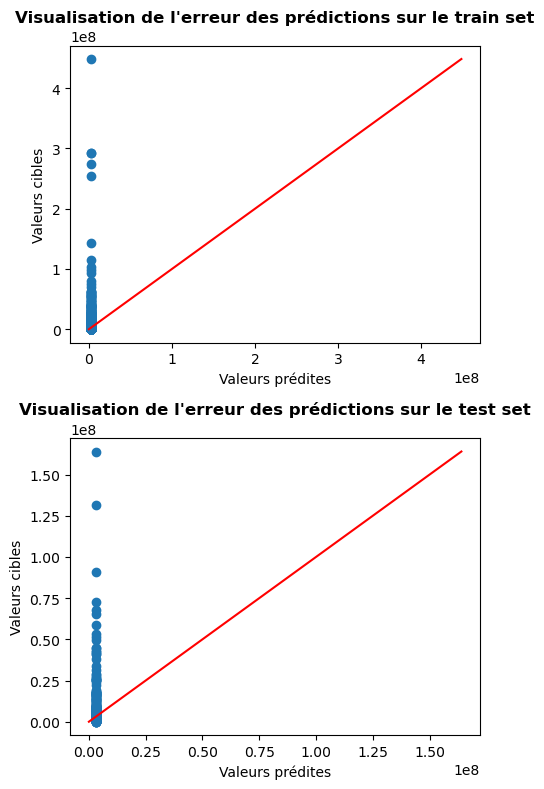

In [12]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_dummy_train, y_train_log, y_pred_dummy_test, y_test_log)

### 3.2 Régression linéaire <a class="anchor" id="3_2"></a>

In [13]:
# Créer un dictionnaire de paramètres
params = {
    'linearregression__fit_intercept': [True, False]
}

# utilisation de la fonction 'final_pipeline'
linear_regression = final_pipeline(X, LinearRegression(), params)

# Entraînement du modèle
linear_regression.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'LargestPropertyUseTypeGFA',
                                                                          'SecondLargestPropertyUseTypeGFA',
                                                                          'ThirdLargestPropertyUseTypeGFA',
                                                                          'EraBuild',
                                                                          'SteamUse_Ratio',
                                                                          'ElectricityUse_Ratio',
                                                                          'NaturalGasUse_Ratio'])])),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'linearregression__fit_intercept': [True, False]},
             scoring='r2')

In [14]:
# Prédictions
y_pred_linear_train = linear_regression.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_linear_test = linear_regression.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
linear_regression_execution_time = time.time() - start_time

In [15]:
affichage_résultats(linear_regression)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearregression__fit_intercept,params,mean_test_score,std_test_score,rank_test_score
0,0.014403,0.000490,0.003001,2.336015e-07,True,{'linearregression__fit_intercept': True},0.496334,0.038064,1
1,0.019804,0.003125,0.004001,6.326360e-04,False,{'linearregression__fit_intercept': False},0.483390,0.055726,2


In [16]:
bestParams(linear_regression)

Les meilleurs paramètres sont :
{'linearregression__fit_intercept': True}


In [17]:
# Affichage des scores
score(linear_regression, X_train, y_train_log, X_test, y_test_log, 
      'Linear Regression', linear_regression_execution_time, df_results)

df_results.loc[df_results['Model'] == 'Linear Regression']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
1,Linear Regression,0.58,0.57,7453760.28,38982612.56,0.002


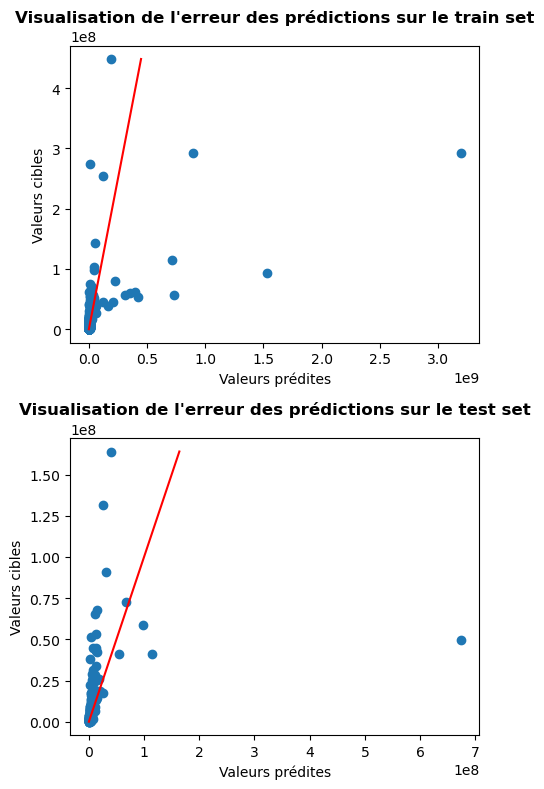

In [18]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_linear_train, y_train_log, y_pred_linear_test, y_test_log)

### 3.3 Régression ridge <a class="anchor" id="3_3"></a>

In [19]:
# Déterminons le paramètre alpha qui va contrôler le paramètre de régularisation (on va en tester 50)
# Ils seront sur une échelle logarithmique
alphas = np.logspace(-5, 5, 50)

# Créer un dictionnaire de paramètres
params = {
      'ridge__alpha': alphas,
}

# utilisation de la fonction 'final_pipeline'
ridge = final_pipeline(X, Ridge(), params)

# Entraînement du modèle
ridge.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'Pro...
       7.90604321e-01, 1.26485522e+00, 2.02358965e+00, 3.23745754e+00,
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05])},
             scoring='r2')

In [20]:
# Prédictions
y_pred_ridge_train = ridge.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_ridge_test = ridge.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
ridge_execution_time = time.time() - start_time

In [21]:
affichage_résultats(ridge)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,mean_test_score,std_test_score,rank_test_score
31,0.013003,1.907349e-07,0.006001,0.000895,21.209509,{'ridge__alpha': 21.209508879201927},0.510913,0.040287,1
30,0.013203,7.486978e-04,0.005801,0.000400,13.257114,{'ridge__alpha': 13.257113655901108},0.510728,0.040344,2
32,0.012803,4.001141e-04,0.005601,0.000490,33.932218,{'ridge__alpha': 33.9322177189533},0.509568,0.040052,3
29,0.013803,4.001618e-04,0.006001,0.000000,8.286428,{'ridge__alpha': 8.286427728546842},0.509440,0.040161,4
28,0.014003,8.946290e-04,0.005401,0.000490,5.179475,{'ridge__alpha': 5.1794746792312125},0.507440,0.039844,5
33,0.013603,2.245528e-03,0.005601,0.000490,54.286754,{'ridge__alpha': 54.286754393238596},0.506353,0.039754,6
27,0.015003,6.324851e-04,0.005801,0.000400,3.237458,{'ridge__alpha': 3.2374575428176464},0.505210,0.039406,7
26,0.017804,3.970819e-03,0.005801,0.001166,2.02359,{'ridge__alpha': 2.0235896477251556},0.502982,0.038978,8
25,0.015803,4.001141e-04,0.005801,0.000748,1.264855,{'ridge__alpha': 1.2648552168552958},0.501139,0.038589,9
34,0.012402,8.004785e-04,0.005801,0.000400,86.851137,{'ridge__alpha': 86.85113737513521},0.500961,0.039511,10


In [22]:
bestParams(ridge)

Les meilleurs paramètres sont :
{'ridge__alpha': 21.209508879201927}


In [23]:
# Affichage des scores
score(ridge, X_train, y_train_log, X_test, y_test_log, 
      'Ridge', ridge_execution_time, df_results)

df_results.loc[df_results['Model'] == 'Ridge']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
2,Ridge,0.57,0.57,7628227.19,40952351.31,0.003


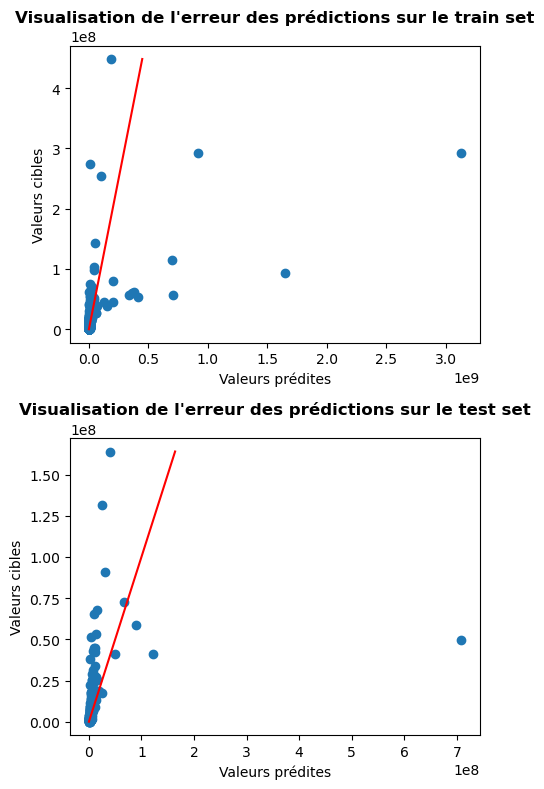

In [24]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_ridge_train, y_train_log, y_pred_ridge_test, y_test_log)

### 3.4 Lasso <a class="anchor" id="3_4"></a>

In [25]:
# Déterminons le paramètre alpha qui va contrôler le paramètre de régularisation (on va en tester 50)
# Ils seront sur une échelle logarithmique
alphas = np.logspace(-5, 5, 100)

# Créer un dictionnaire de paramètres
params = {
      'lasso__alpha': alphas,
}

# utilisation de la fonction 'final_pipeline'
lasso = final_pipeline(X, Lasso(), params)

# Entraînement du modèle
lasso.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'Pro...
       4.75081016e+02, 5.99484250e+02, 7.56463328e+02, 9.54548457e+02,
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05])},
             scoring='r2')

In [26]:
# Prédictions
y_pred_lasso_train = lasso.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_lasso_test = lasso.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
lasso_execution_time = time.time() - start_time

In [27]:
affichage_résultats(lasso)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,mean_test_score,std_test_score,rank_test_score
27,0.021805,0.002639,0.005001,8.946290e-04,0.005337,{'lasso__alpha': 0.005336699231206307},0.512392,0.035242,1
28,0.020404,0.003073,0.005601,8.000971e-04,0.006734,{'lasso__alpha': 0.006734150657750821},0.512352,0.034641,2
26,0.026606,0.010876,0.004801,4.000428e-04,0.004229,{'lasso__alpha': 0.0042292428743894986},0.512003,0.035829,3
25,0.021205,0.004535,0.004401,8.000851e-04,0.003352,{'lasso__alpha': 0.003351602650938841},0.511271,0.036322,4
29,0.019804,0.001940,0.005401,4.901350e-04,0.008498,{'lasso__alpha': 0.008497534359086439},0.510921,0.034791,5
24,0.024405,0.003263,0.004801,7.487233e-04,0.002656,{'lasso__alpha': 0.0026560877829466868},0.510064,0.036892,6
23,0.027206,0.004309,0.005001,1.095496e-03,0.002105,{'lasso__alpha': 0.00210490414451202},0.509089,0.037284,7
22,0.025806,0.003125,0.005001,1.784161e-07,0.001668,{'lasso__alpha': 0.0016681005372000592},0.507990,0.037591,8
30,0.021005,0.002684,0.005201,3.996374e-04,0.010723,{'lasso__alpha': 0.010722672220103232},0.507959,0.035194,9
21,0.027806,0.004355,0.005401,4.899988e-04,0.001322,{'lasso__alpha': 0.0013219411484660286},0.506331,0.037750,10


In [28]:
bestParams(lasso)

Les meilleurs paramètres sont :
{'lasso__alpha': 0.005336699231206307}


In [29]:
# Affichage des scores
score(lasso, X_train, y_train_log, X_test, y_test_log, 
      'Lasso', lasso_execution_time, df_results)

df_results.loc[df_results['Model'] == 'Lasso']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
3,Lasso,0.56,0.58,7536817.53,39975143.61,0.003001


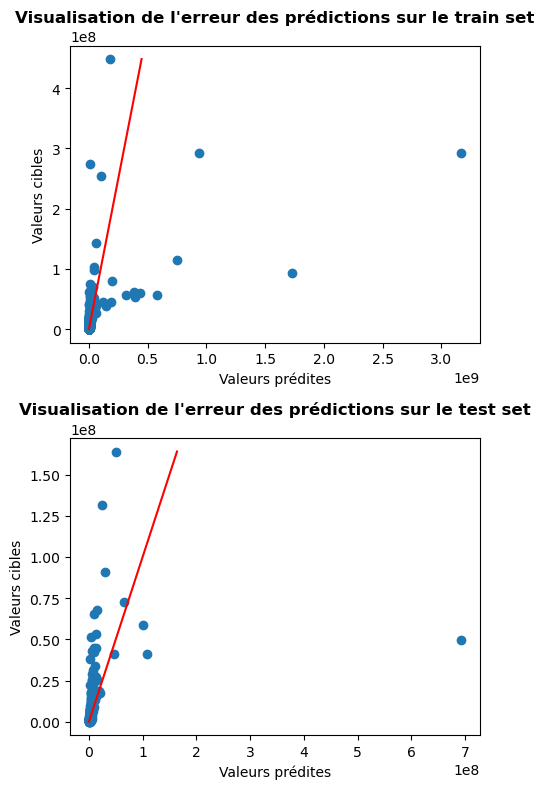

In [30]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_lasso_train, y_train_log, y_pred_lasso_test, y_test_log)

### 3.5 Elastic net <a class="anchor" id="3_5"></a>

In [31]:
# Déterminons le paramètre alpha qui va contrôler le paramètre de régularisation (on va en tester 50)
# Ils seront sur une échelle logarithmique
alphas = np.logspace(-5, 5, 50)

# Créer un dictionnaire de paramètres
params = {
    'elasticnet__alpha': alphas, 
    'elasticnet__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
    'elasticnet__precompute': [True, False],
    'elasticnet__selection': ['cyclic', 'random']
}

# utilisation de la fonction 'final_pipeline'
elastic_net = final_pipeline(X, ElasticNet(random_state=0), params)

# Entraînement du modèle
elastic_net.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'Pro...
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05]),
                         'elasticnet__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'elasticnet__precompute': [True, False],
                         'elasticnet__selection': ['cyclic', 'random']},
             scoring='r2')

In [32]:
# Prédictions
y_pred_elastic_net_train = elastic_net.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_elastic_net_test = elastic_net.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
elastic_net_time = time.time() - start_time

In [33]:
affichage_résultats(elastic_net)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_elasticnet__alpha,param_elasticnet__l1_ratio,param_elasticnet__precompute,param_elasticnet__selection,params,mean_test_score,std_test_score,rank_test_score
294,0.021205,0.003125,0.004201,3.999949e-04,0.007197,0.75,False,cyclic,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.512582,0.035722,1
292,0.021805,0.002786,0.004201,3.999710e-04,0.007197,0.75,True,cyclic,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.512582,0.035722,1
293,0.033607,0.006408,0.004401,4.899987e-04,0.007197,0.75,True,random,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.512561,0.035689,3
295,0.031007,0.004859,0.004601,8.001447e-04,0.007197,0.75,False,random,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.512561,0.035689,3
291,0.040409,0.002155,0.004401,4.898819e-04,0.007197,0.5,False,random,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.512303,0.037240,5
289,0.039609,0.003879,0.004801,4.000903e-04,0.007197,0.5,True,random,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.512303,0.037240,5
290,0.023005,0.002281,0.008402,7.814479e-03,0.007197,0.5,False,cyclic,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.512298,0.037268,7
288,0.021805,0.001721,0.004401,4.898820e-04,0.007197,0.5,True,cyclic,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.512298,0.037268,7
298,0.022005,0.003407,0.005001,9.536743e-08,0.007197,1,False,cyclic,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.512123,0.034559,9
296,0.020605,0.002154,0.004401,1.020329e-03,0.007197,1,True,cyclic,"{'elasticnet__alpha': 0.0071968567300115215, '...",0.512123,0.034559,9


In [34]:
# Affichage des scores
score(elastic_net, X_train, y_train_log, X_test, y_test_log, 
      'Elactic Net', elastic_net_time, df_results)

df_results.loc[df_results['Model'] == 'Elactic Net']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
4,Elactic Net,0.56,0.57,7553267.26,40077875.31,0.003


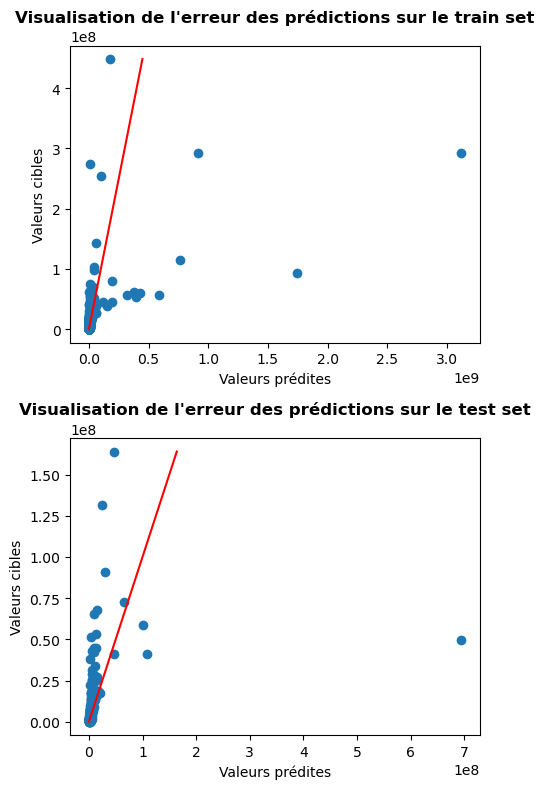

In [35]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_elastic_net_train, y_train_log, y_pred_elastic_net_test, y_test_log)

### 3.6 Linear SVR <a class="anchor" id="3_6"></a>

In [36]:
# Créer un dictionnaire de paramètres
params = {
    'linearsvr__max_iter': [1000, 10000, 50000, 100000],
    'linearsvr__C': np.logspace(-3, 3, 10),
    'linearsvr__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'linearsvr__epsilon': [0.1, 0.2, 0.5, 0.9]
}

# utilisation de la fonction 'final_pipeline'
linear_svr = final_pipeline(X, LinearSVR(), params)

# Entraînement du modèle
linear_svr.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'Pro...
             param_grid={'linearsvr__C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'linearsvr__epsilon': [0.1, 0.2, 0.5, 0.9],
                         'linearsvr__loss': ['epsilon_insensitive',
                                             'squared_epsilon_insensitive'],
                         'linearsvr__max_iter': [1000, 10000, 50000, 100000]},
             scoring='r2')

In [37]:
# Prédictions
y_pred_linear_svr_train = linear_svr.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_linear_svr_test = linear_svr.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
linear_svr_execution_time = time.time() - start_time

In [38]:
affichage_résultats(linear_svr)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearsvr__C,param_linearsvr__epsilon,param_linearsvr__loss,param_linearsvr__max_iter,params,mean_test_score,std_test_score,rank_test_score
133,0.069415,0.003612,0.005201,4.000427e-04,0.464159,0.1,squared_epsilon_insensitive,10000,"{'linearsvr__C': 0.46415888336127775, 'linears...",0.497387,0.037579,1
135,0.071416,0.003721,0.005201,7.483792e-04,0.464159,0.1,squared_epsilon_insensitive,100000,"{'linearsvr__C': 0.46415888336127775, 'linears...",0.497369,0.037617,2
134,0.082619,0.016011,0.005401,4.901155e-04,0.464159,0.1,squared_epsilon_insensitive,50000,"{'linearsvr__C': 0.46415888336127775, 'linears...",0.497368,0.037619,3
132,0.063414,0.010054,0.005207,3.972190e-04,0.464159,0.1,squared_epsilon_insensitive,1000,"{'linearsvr__C': 0.46415888336127775, 'linears...",0.497359,0.037761,4
140,0.053612,0.000800,0.005035,6.740167e-05,0.464159,0.2,squared_epsilon_insensitive,1000,"{'linearsvr__C': 0.46415888336127775, 'linears...",0.496994,0.036708,5
142,0.065815,0.003710,0.005801,3.999949e-04,0.464159,0.2,squared_epsilon_insensitive,50000,"{'linearsvr__C': 0.46415888336127775, 'linears...",0.496986,0.036603,6
143,0.067415,0.003721,0.005601,4.900182e-04,0.464159,0.2,squared_epsilon_insensitive,100000,"{'linearsvr__C': 0.46415888336127775, 'linears...",0.496936,0.036632,7
141,0.070216,0.009284,0.006201,4.002333e-04,0.464159,0.2,squared_epsilon_insensitive,10000,"{'linearsvr__C': 0.46415888336127775, 'linears...",0.496914,0.036601,8
197,0.485310,0.004666,0.005001,2.132481e-07,10.0,0.1,squared_epsilon_insensitive,10000,"{'linearsvr__C': 10.0, 'linearsvr__epsilon': 0...",0.495692,0.039655,9
165,0.299463,0.012565,0.005201,4.000903e-04,2.154435,0.1,squared_epsilon_insensitive,10000,"{'linearsvr__C': 2.154434690031882, 'linearsvr...",0.495285,0.038278,10


In [39]:
bestParams(linear_svr)

Les meilleurs paramètres sont :
{'linearsvr__C': 0.46415888336127775, 'linearsvr__epsilon': 0.1, 'linearsvr__loss': 'squared_epsilon_insensitive', 'linearsvr__max_iter': 10000}


In [40]:
# Affichage des scores
score(linear_svr, X_train, y_train_log, X_test, y_test_log, 
      'Linear SVR', linear_svr_execution_time, df_results)

df_results.loc[df_results['Model'] == 'Linear SVR']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
5,Linear SVR,0.58,0.57,7399739.86,37238861.61,0.004001


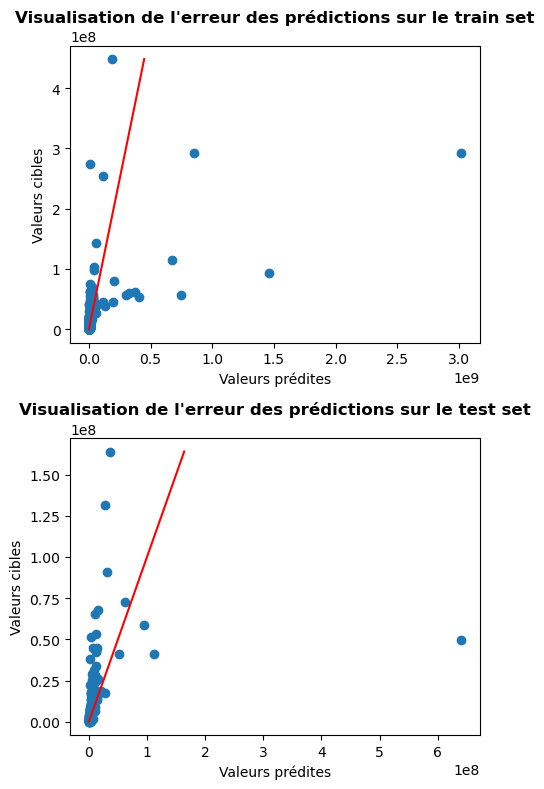

In [41]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_linear_svr_train, y_train_log, y_pred_linear_svr_test, y_test_log)

### 3.7 Forêts aléatoires <a class="anchor" id="3_7"></a>

In [42]:
# Créer un dictionnaire de paramètres
params = {
    'randomforestregressor__n_estimators': [100, 200, 300, 500, 1000],
    'randomforestregressor__max_depth': [3, 4, 5, 6, 7, 8, 9]
}

# utilisation de la fonction 'final_pipeline'
random_forest = final_pipeline(X, RandomForestRegressor(), params)

# Entraînement du modèle
random_forest.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'Pro...
                                                                          'LargestPropertyUseTypeGFA',
                                                                          'SecondLargestPropertyUseTypeGFA',
                                                                          'ThirdLargestPropertyUseTypeGFA',
                                                                          'EraBuild',
                                                                          'SteamUse_Ratio',
                                                                          'ElectricityUse_Ratio',
                                                                          'NaturalGasUse_Ratio'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [3, 4, 5, 6, 7, 8,
                                                              9],
                         'randomforestregressor__n_estimators': [100, 200, 300,
                                                                 500, 1000]},
             scoring='r2')

In [43]:
# Prédictions
y_pred_random_forest_train = random_forest.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_random_forest_test = random_forest.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
random_forest_execution_time = time.time() - start_time

In [44]:
affichage_résultats(random_forest)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_depth,param_randomforestregressor__n_estimators,params,mean_test_score,std_test_score,rank_test_score
31,2.626192,0.025388,0.021605,4.898625e-04,9,200,"{'randomforestregressor__max_depth': 9, 'rando...",0.679034,0.048305,1
34,9.285894,0.331889,0.058413,1.020104e-03,9,1000,"{'randomforestregressor__max_depth': 9, 'rando...",0.677707,0.048804,2
27,3.303745,0.027920,0.029607,8.001685e-04,8,300,"{'randomforestregressor__max_depth': 8, 'rando...",0.677429,0.046981,3
33,6.199198,0.187848,0.035408,4.883827e-03,9,500,"{'randomforestregressor__max_depth': 9, 'rando...",0.677278,0.047220,4
26,2.206297,0.025109,0.021405,4.898430e-04,8,200,"{'randomforestregressor__max_depth': 8, 'rando...",0.676883,0.045497,5
28,5.535648,0.126587,0.043810,4.002334e-04,8,500,"{'randomforestregressor__max_depth': 8, 'rando...",0.676877,0.047428,6
29,10.852447,0.108427,0.080618,2.871079e-03,8,1000,"{'randomforestregressor__max_depth': 8, 'rando...",0.676533,0.048332,7
32,3.921684,0.042565,0.030207,1.720895e-03,9,300,"{'randomforestregressor__max_depth': 9, 'rando...",0.676013,0.048212,8
30,1.334101,0.051716,0.013003,1.168008e-07,9,100,"{'randomforestregressor__max_depth': 9, 'rando...",0.675177,0.047294,9
21,1.783602,0.014854,0.019805,4.000903e-04,7,200,"{'randomforestregressor__max_depth': 7, 'rando...",0.674167,0.047444,10


In [45]:
bestParams(random_forest)

Les meilleurs paramètres sont :
{'randomforestregressor__max_depth': 9, 'randomforestregressor__n_estimators': 200}


In [46]:
# Affichage des scores
score(random_forest, X_train, y_train_log, X_test, y_test_log, 
      'Random Forest', random_forest_execution_time, df_results)

df_results.loc[df_results['Model'] == 'Random Forest']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
6,Random Forest,0.89,0.77,3643648.91,8970142.39,0.015003


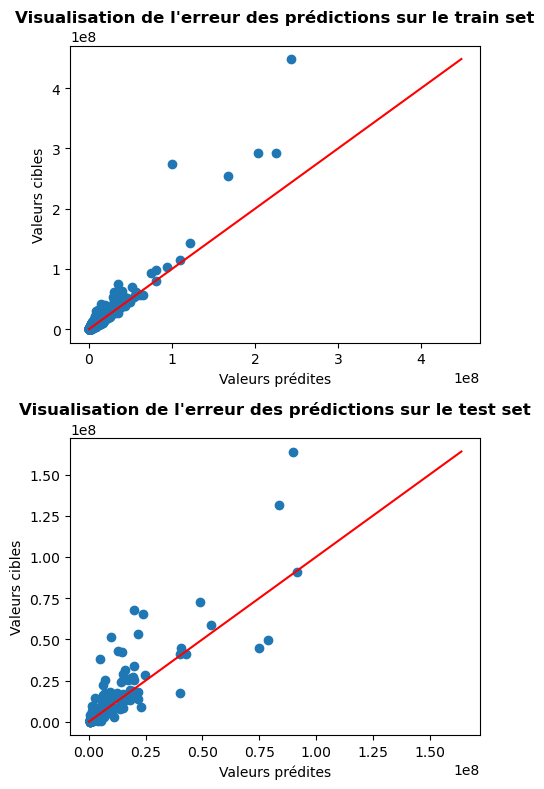

In [47]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_random_forest_train, y_train_log, y_pred_random_forest_test, y_test_log)

### 3.8  XGBoost <a class="anchor" id="3_8"></a>

In [48]:
# Créer un dictionnaire de paramètres
params = {
    'xgbregressor__n_estimators': [100, 200, 300, 500],
    'xgbregressor__max_depth': [3, 4, 5, 6, 7],
    'xgbregressor__learning_rate': [0.01, 0.1, 0.2],
    'xgbregressor__gamma': [0, 0.05, 0.1, 0.2]
}

# utilisation de la fonction 'final_pipeline'
xgboost = final_pipeline(X, XGBRegressor(), params)

# Entraînement du modèle
xgboost.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'Pro...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbregressor__gamma': [0, 0.05, 0.1, 0.2],
                         'xgbregressor__learning_rate': [0.01, 0.1, 0.2],
                         'xgbregressor__max_depth': [3, 4, 5, 6, 7],
                         'xgbregressor__n_estimators': [100, 200, 300, 500]},
             scoring='r2')

In [49]:
# Prédictions
y_pred_xgboost_train = xgboost.best_estimator_.predict(X_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_xgboost_test = xgboost.best_estimator_.predict(X_test)

# Calcul du temps d'exécution
xgboost_execution_time = time.time() - start_time

In [50]:
affichage_résultats(xgboost)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__gamma,param_xgbregressor__learning_rate,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,params,mean_test_score,std_test_score,rank_test_score
201,0.090621,0.001201,0.008002,5.560829e-07,0.2,0.1,3,200,"{'xgbregressor__gamma': 0.2, 'xgbregressor__le...",0.707926,0.039795,1
203,0.137031,0.004562,0.008202,4.001857e-04,0.2,0.1,3,500,"{'xgbregressor__gamma': 0.2, 'xgbregressor__le...",0.707926,0.039795,1
202,0.105024,0.004561,0.007401,4.902526e-04,0.2,0.1,3,300,"{'xgbregressor__gamma': 0.2, 'xgbregressor__le...",0.707926,0.039795,1
200,0.062014,0.001096,0.008202,7.486596e-04,0.2,0.1,3,100,"{'xgbregressor__gamma': 0.2, 'xgbregressor__le...",0.707659,0.040668,4
140,0.067615,0.006802,0.008803,4.000908e-04,0.1,0.1,3,100,"{'xgbregressor__gamma': 0.1, 'xgbregressor__le...",0.706348,0.041988,5
80,0.069815,0.005708,0.009403,1.019908e-03,0.05,0.1,3,100,"{'xgbregressor__gamma': 0.05, 'xgbregressor__l...",0.706227,0.040362,6
228,0.065614,0.001960,0.006202,4.000666e-04,0.2,0.2,5,100,"{'xgbregressor__gamma': 0.2, 'xgbregressor__le...",0.705994,0.044196,7
229,0.079218,0.001834,0.006602,4.901351e-04,0.2,0.2,5,200,"{'xgbregressor__gamma': 0.2, 'xgbregressor__le...",0.705994,0.044196,7
230,0.098822,0.006211,0.006601,4.898625e-04,0.2,0.2,5,300,"{'xgbregressor__gamma': 0.2, 'xgbregressor__le...",0.705994,0.044196,7
231,0.130229,0.002483,0.007802,7.486086e-04,0.2,0.2,5,500,"{'xgbregressor__gamma': 0.2, 'xgbregressor__le...",0.705994,0.044196,7


In [51]:
bestParams(xgboost)

Les meilleurs paramètres sont :
{'xgbregressor__gamma': 0.2, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 200}


In [52]:
# Affichage des scores
score(xgboost, X_train, y_train_log, X_test, y_test_log, 
      'XGBoost', xgboost_execution_time, df_results)

df_results.loc[df_results['Model'] == 'XGBoost']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
7,XGBoost,0.83,0.78,4003271.85,9925096.99,0.004001


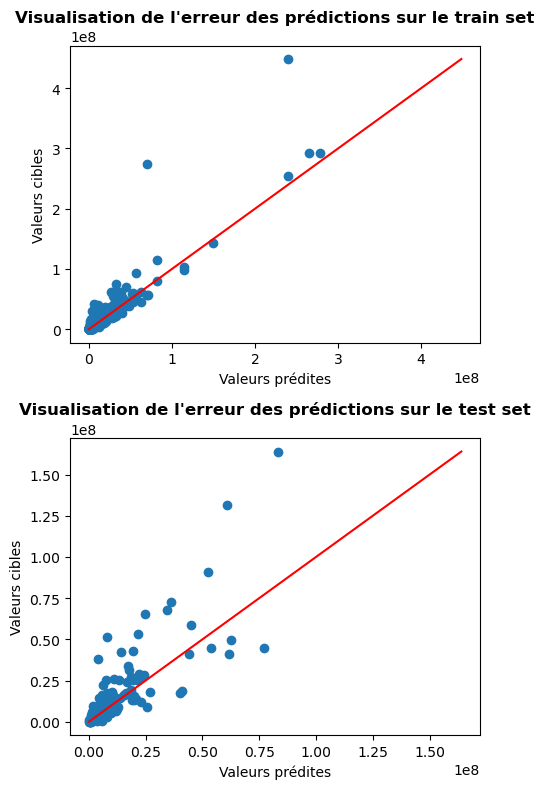

In [53]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_xgboost_train, y_train_log, y_pred_xgboost_test, y_test_log)

## 4. Choix du modèle <a class="anchor" id="4"></a>

### 4.1  Affichage des scores <a class="anchor" id="4_1"></a>

In [54]:
df_results = df_results.sort_values('R2_test', ascending=True)
df_results

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
0,Dummy Regressor,0.00,-0.01,7568317.25,18210191.08,0.004000
1,Linear Regression,0.58,0.57,7453760.28,38982612.56,0.002000
2,Ridge,0.57,0.57,7628227.19,40952351.31,0.003000
4,Elactic Net,0.56,0.57,7553267.26,40077875.31,0.003000
5,Linear SVR,0.58,0.57,7399739.86,37238861.61,0.004001
3,Lasso,0.56,0.58,7536817.53,39975143.61,0.003001
6,Random Forest,0.89,0.77,3643648.91,8970142.39,0.015003
7,XGBoost,0.83,0.78,4003271.85,9925096.99,0.004001


### 4.2  Comparaison des scores obtenus <a class="anchor" id="4_2"></a>

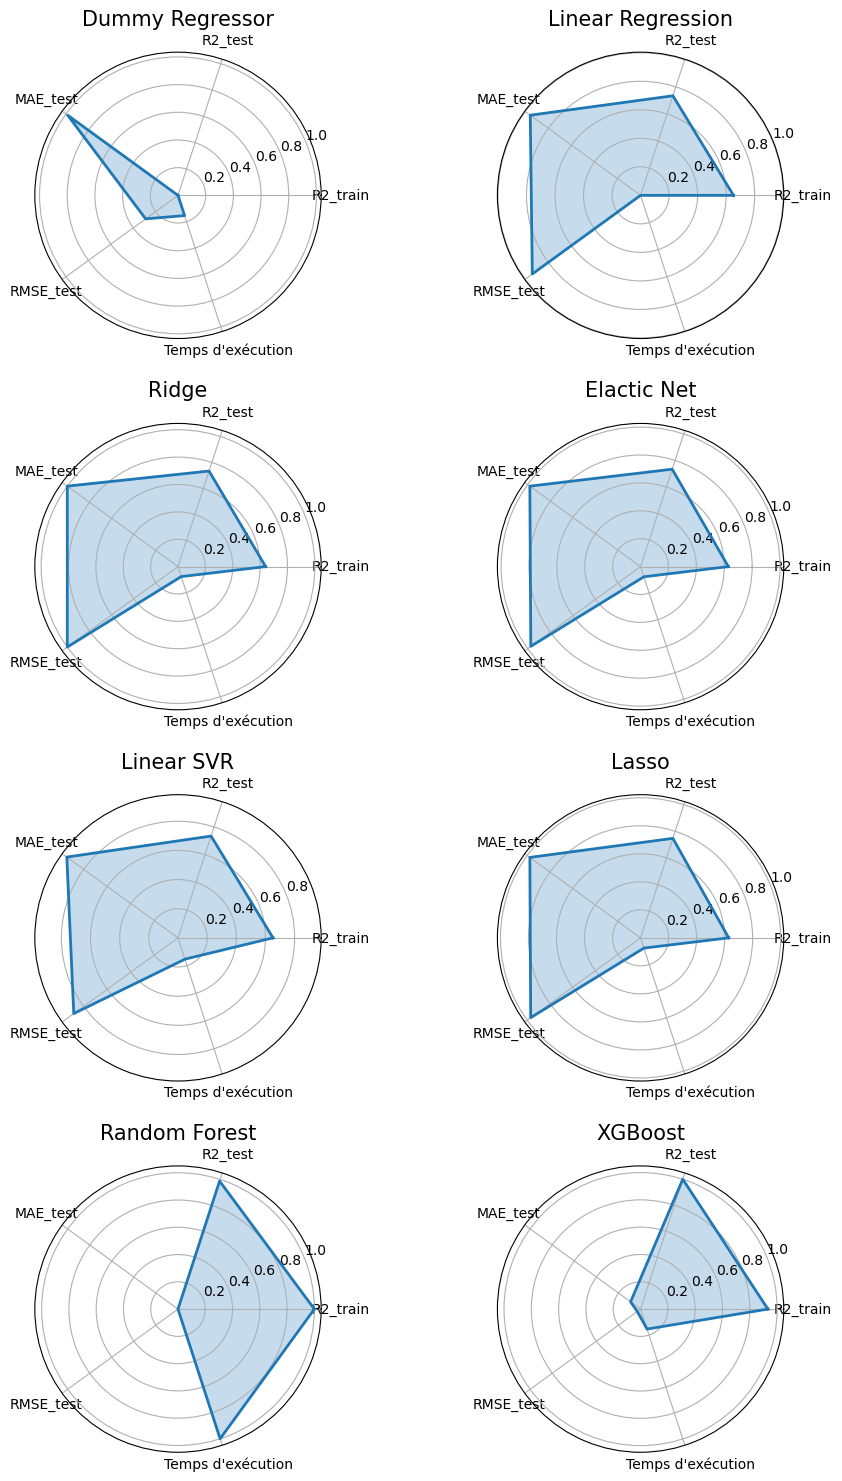

In [55]:
from sklearn.preprocessing import MinMaxScaler

# Exclure la colonne 'Model' pour la normalisation
scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(df_results.iloc[:, 1:])

# Création du radar plot
angles = np.linspace(0, 2 * np.pi, len(df_results.columns)-1, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

# Création des 4x2 radars plots pour chaque modèle
fig, axes = plt.subplots(4, 2, figsize=(12, 15), subplot_kw={'polar': True})
fig.subplots_adjust(wspace=0, hspace=2)

for i, ax in enumerate(axes.flatten()):  # Utilisez .flatten() pour parcourir les sous-axes
    # Sélection des valeurs normalisées des caractéristiques pour le modèle i
    values = normalized_values[i]  # Exclut la première colonne (Model)
    values = np.concatenate((values, [values[0]]))
    model_name = df_results.iloc[i]['Model']
    # Tracé du radar plot pour le modèle i
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(df_results.columns[1:], fontsize=10)
    ax.set_title(model_name, fontsize=15)

plt.tight_layout()
plt.show()

### 4.3  Comparaison par le coefficient de détermination <a class="anchor" id="4_3"></a>

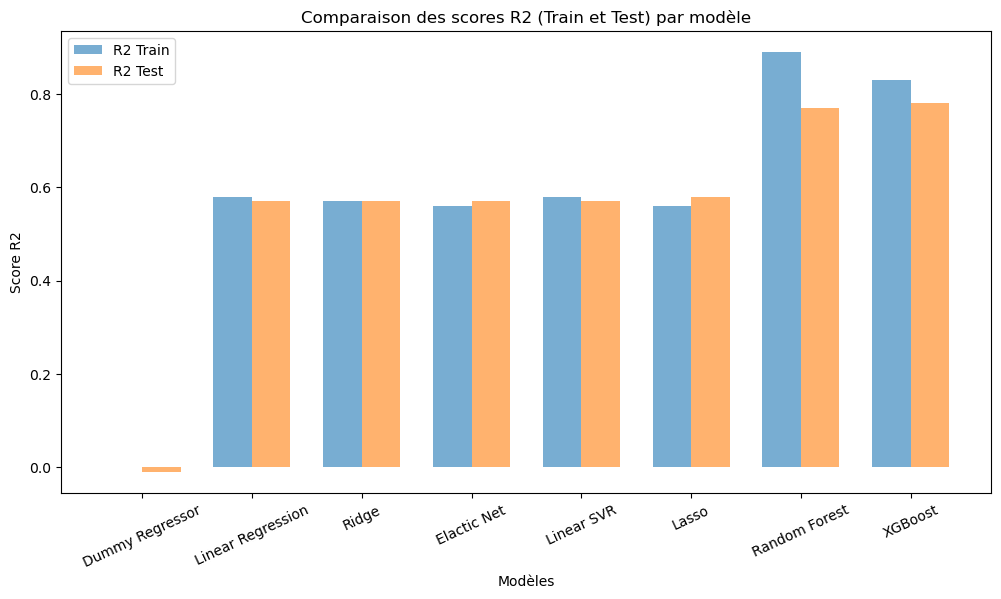

In [56]:
# Créer une liste d'indices pour chaque modèle
model_indices = np.arange(len(df_results['Model']))

# Créer une figure et un axe pour les graphiques
fig, ax = plt.subplots(figsize=(12, 6))

# Largeur des barres
bar_width = 0.35

# Tracer les scores R2 d'entraînement et de test côte à côte
train_bars = ax.bar(model_indices - bar_width/2, df_results['R2_train'], bar_width, label='R2 Train', alpha=0.6)
test_bars = ax.bar(model_indices + bar_width/2, df_results['R2_test'], bar_width, label='R2 Test', alpha=0.6)

# Ajoutez des étiquettes et une légende
ax.set_xlabel('Modèles')
ax.set_ylabel('Score R2')
ax.set_title('Comparaison des scores R2 (Train et Test) par modèle')
ax.set_xticks(model_indices)
ax.set_xticklabels(df_results['Model'], rotation=25)
ax.legend()
plt.show()

### 4.4  Comparaison par l'erreur <a class="anchor" id="4_4"></a>

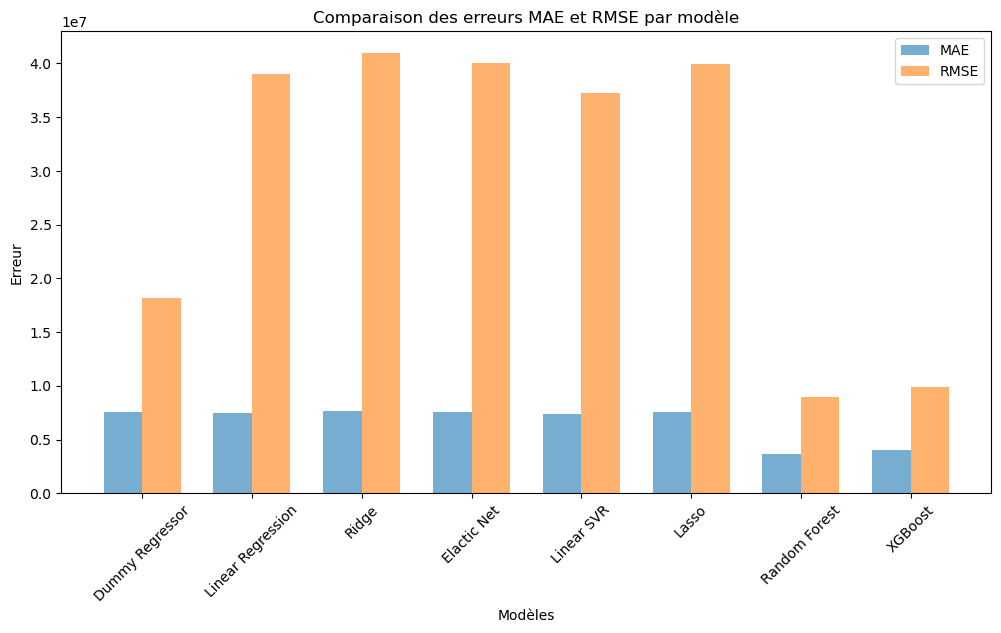

In [57]:
# Créer une liste d'indices pour chaque modèle
model_indices = np.arange(len(df_results['Model']))

# Largeur des barres
bar_width = 0.35

# Créer une figure et un axe pour les graphiques
fig, ax = plt.subplots(figsize=(12, 6))

# Tracer les erreurs MAE et RMSE côte à côte pour chaque modèle
mae_bars = ax.bar(model_indices - bar_width/2, df_results['MAE_test'], bar_width, label='MAE', alpha=0.6)
rmse_bars = ax.bar(model_indices + bar_width/2, df_results['RMSE_test'], bar_width, label='RMSE', alpha=0.6)

# Ajouter des étiquettes et une légende
ax.set_xlabel('Modèles')
ax.set_ylabel('Erreur')
ax.set_title('Comparaison des erreurs MAE et RMSE par modèle')
ax.set_xticks(model_indices)
ax.set_xticklabels(df_results['Model'], rotation=45)
ax.legend()
plt.show()

### 4.5  Comparaison par le temps d'exécution <a class="anchor" id="4_5"></a>

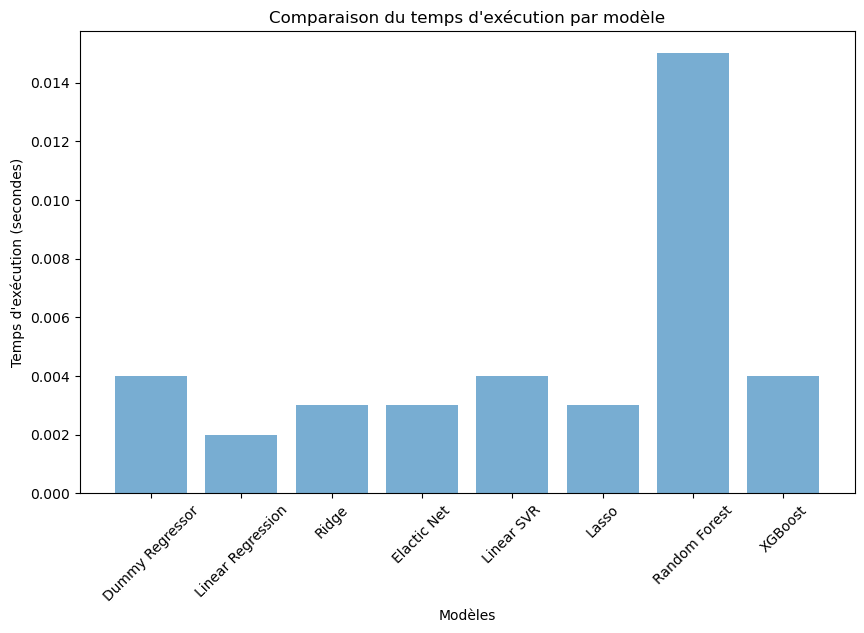

In [58]:
# Créer une figure et un axe pour les graphiques
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer le temps d'exécution pour chaque modèle
ax.bar(df_results['Model'], df_results["Temps d'exécution"], label='Temps d\'exécution', alpha=0.6)

# Ajouter des étiquettes et une légende
ax.set_xlabel('Modèles')
ax.set_ylabel("Temps d'exécution (secondes)")
ax.set_title("Comparaison du temps d'exécution par modèle")

# Afficher le graphique
plt.xticks(rotation=45)
plt.show()

Nous choisirons donc le modèle de boosting : XGBoost regressor.

Celui-ci nous permet de maximiser le coefficient de détermination R2, de diminuer le plus possible l'erreur et de minimiser le temps d'exécution. 

### 4.6  Courbe d'apprentissage sur le XGBoost <a class="anchor" id="4_6"></a>

Nombre de données par lot :
[  55  171  287  403  519  636  752  868  984 1101]


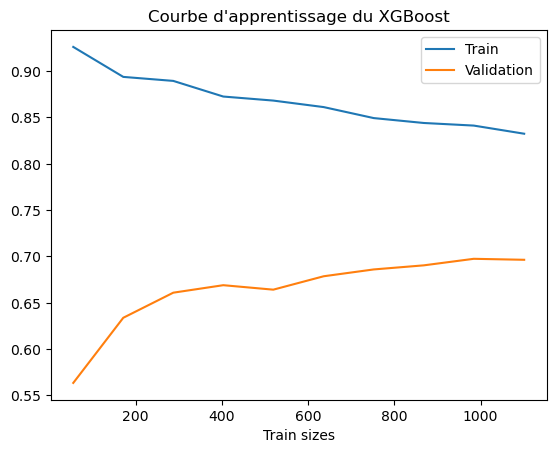

In [59]:
# Traçons la courbe d'apprentissage et le score de validation croisé associé
N, train_score, val_score = learning_curve(xgboost.best_estimator_, X_train, y_train_log,
                            train_sizes= np.linspace(0.05, 1.0, 10), cv=15)

print('Nombre de données par lot :')
print(N)
plt.plot(N, train_score.mean(axis=1), label='Train')
plt.plot(N, val_score.mean(axis=1), label='Validation')
plt.xlabel('Train sizes')
plt.title("Courbe d'apprentissage du XGBoost")
plt.legend()
plt.show()

On peut voir ici que rajouter des données d'entraînement n'améliorera pas notre modèle.

## 5. Evaluation de l'intérêt de l'ENERGY STAR score pour la prédiction <a class="anchor" id="5"></a>

### 5.1 Preprocessing <a class="anchor" id="5_1"></a>

In [60]:
df_energy = df.dropna()
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PrimaryPropertyType              960 non-null    object 
 1   Neighborhood                     960 non-null    object 
 2   NumberofBuildings                960 non-null    float64
 3   NumberofFloors                   960 non-null    int64  
 4   PropertyGFATotal                 960 non-null    int64  
 5   PropertyGFAParking               960 non-null    int64  
 6   LargestPropertyUseType           960 non-null    object 
 7   LargestPropertyUseTypeGFA        960 non-null    float64
 8   SecondLargestPropertyUseType     960 non-null    object 
 9   SecondLargestPropertyUseTypeGFA  960 non-null    float64
 10  ThirdLargestPropertyUseType      960 non-null    object 
 11  ThirdLargestPropertyUseTypeGFA   960 non-null    float64
 12  ENERGYSTARScore      

In [61]:
# Instancier X et y
X_energy = df_energy.drop(['TARGET_SiteEnergyUse(kBtu)', 'TARGET_TotalGHGEmissions'], axis=1)
y_energy = df_energy['TARGET_SiteEnergyUse(kBtu)']

# Mettre y au log
log_transformer = FunctionTransformer(func=np.log, inverse_func=np.exp)
y_energy_log = log_transformer.transform(y_energy)

In [62]:
# On divise notre train set et test set
X_energy_train, X_energy_test, y_energy_log_train, y_energy_log_test = \
train_test_split(X_energy, y_energy_log, train_size=0.8, random_state=0)

# Vérifions la taille de notre train set et de notre test set
print(f'Nous avons X_energy_train de forme {X_energy_train.shape} et y_energy_log_train de forme {y_energy_log_train.shape}.')
print()
print(f'Nous avons X_energy_test de forme {X_energy_test.shape} et y_energy_log_test de forme {y_energy_log_test.shape}.')

Nous avons X_energy_train de forme (768, 17) et y_energy_log_train de forme (768,).

Nous avons X_energy_test de forme (192, 17) et y_energy_log_test de forme (192,).


### 5.2 Modélisation du XGBoost avec l'ENERGY STAR score  <a class="anchor" id="5_2"></a>

In [63]:
# Créer un dictionnaire de paramètres
params = {
    'xgbregressor__n_estimators': [100, 200, 300, 500],
    'xgbregressor__max_depth': [3, 4, 5, 6, 7],
    'xgbregressor__learning_rate': [0.01, 0.1, 0.2],
    'xgbregressor__gamma': [0, 0.05, 0.1, 0.2]
}

# utilisation de la fonction 'final_pipeline'
xgboost_ENERGY = final_pipeline(X_energy, XGBRegressor(), params)

# Entraînement du modèle
xgboost_ENERGY.fit(X_energy_train , y_energy_log_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('qualitatif',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['PrimaryPropertyType',
                                                                          'Neighborhood',
                                                                          'LargestPropertyUseType',
                                                                          'SecondLargestPropertyUseType',
                                                                          'ThirdLargestPropertyUseType']),
                                                                        ('quantitatif',
                                                                         StandardScaler(),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'Pro...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbregressor__gamma': [0, 0.05, 0.1, 0.2],
                         'xgbregressor__learning_rate': [0.01, 0.1, 0.2],
                         'xgbregressor__max_depth': [3, 4, 5, 6, 7],
                         'xgbregressor__n_estimators': [100, 200, 300, 500]},
             scoring='r2')

In [64]:
# Prédictions
y_pred_xgboost_energy_train = xgboost_ENERGY.best_estimator_.predict(X_energy_train)

# Prédictions sur Test Set
# Enregistrement du temps actuel
start_time = time.time()

y_pred_xgboost_energy_test = xgboost_ENERGY.best_estimator_.predict(X_energy_test )

# Calcul du temps d'exécution
xgboost_energy_execution_time = time.time() - start_time

In [65]:
affichage_résultats(xgboost_ENERGY)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__gamma,param_xgbregressor__learning_rate,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,params,mean_test_score,std_test_score,rank_test_score
21,0.100223,0.000749,0.008802,7.485322e-04,0,0.1,3,200,"{'xgbregressor__gamma': 0, 'xgbregressor__lear...",0.869055,0.009517,1
81,0.093421,0.003879,0.008402,1.497090e-03,0.05,0.1,3,200,"{'xgbregressor__gamma': 0.05, 'xgbregressor__l...",0.868998,0.009154,2
83,0.139431,0.004455,0.007001,3.504023e-07,0.05,0.1,3,500,"{'xgbregressor__gamma': 0.05, 'xgbregressor__l...",0.868997,0.009154,3
82,0.107824,0.001600,0.007402,4.901740e-04,0.05,0.1,3,300,"{'xgbregressor__gamma': 0.05, 'xgbregressor__l...",0.868997,0.009154,3
22,0.137631,0.001357,0.007602,4.900377e-04,0,0.1,3,300,"{'xgbregressor__gamma': 0, 'xgbregressor__lear...",0.868675,0.010836,5
23,0.224050,0.004518,0.009002,6.325605e-04,0,0.1,3,500,"{'xgbregressor__gamma': 0, 'xgbregressor__lear...",0.867782,0.012613,6
141,0.081018,0.002450,0.007802,7.484557e-04,0.1,0.1,3,200,"{'xgbregressor__gamma': 0.1, 'xgbregressor__le...",0.865453,0.008680,7
142,0.094821,0.002228,0.007202,7.484557e-04,0.1,0.1,3,300,"{'xgbregressor__gamma': 0.1, 'xgbregressor__le...",0.865453,0.008680,7
143,0.124028,0.003848,0.007602,4.899600e-04,0.1,0.1,3,500,"{'xgbregressor__gamma': 0.1, 'xgbregressor__le...",0.865453,0.008680,7
100,0.054812,0.002040,0.006001,1.168008e-07,0.05,0.2,3,100,"{'xgbregressor__gamma': 0.05, 'xgbregressor__l...",0.863594,0.010859,10


In [66]:
bestParams(xgboost_ENERGY)

Les meilleurs paramètres sont :
{'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 200}


In [67]:
# Affichage des scores
score(xgboost_ENERGY, X_energy_train, y_energy_log_train, X_energy_test, y_energy_log_test, 
      'XGBoost_ENERGY', xgboost_energy_execution_time, df_results)

df_results.loc[df_results['Model'] == 'XGBoost_ENERGY']

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
8,XGBoost_ENERGY,0.96,0.82,4030301.56,28132278.22,0.003001


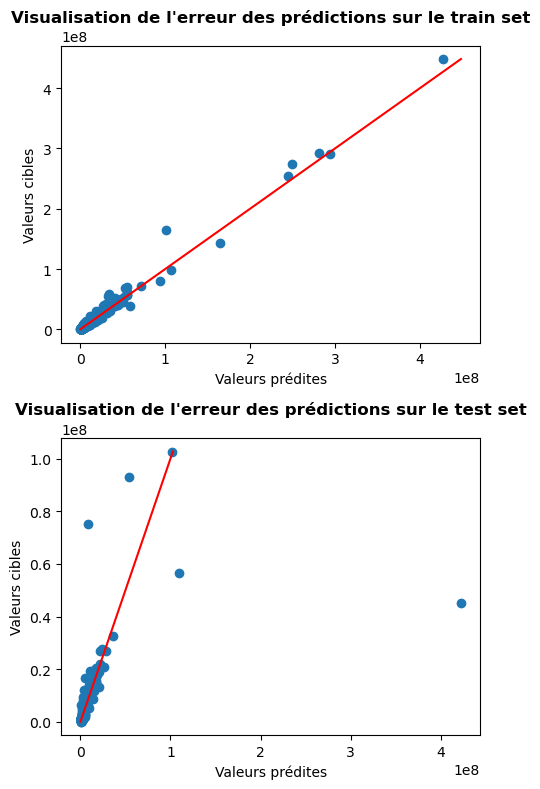

In [68]:
# Visualisation de l'erreur sur le train set et sur le test set
visualisation_erreur(y_pred_xgboost_energy_train, y_energy_log_train, y_pred_xgboost_energy_test, y_energy_log_test)

Nombre de données par lot :
[ 35 111 186 262 338 413 489 564 640 716]


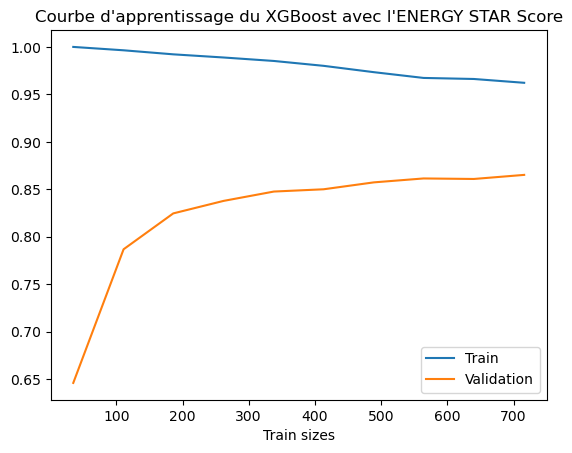

In [69]:
# Traçons la courbe d'apprentissage et le score de validation croisé associé
N, train_score, val_score = learning_curve(xgboost_ENERGY.best_estimator_, X_energy_train, y_energy_log_train,
                            train_sizes= np.linspace(0.05, 1.0, 10), cv=15)

print('Nombre de données par lot :')
print(N)
plt.plot(N, train_score.mean(axis=1), label='Train')
plt.plot(N, val_score.mean(axis=1), label='Validation')
plt.xlabel('Train sizes')
plt.title("Courbe d'apprentissage du XGBoost avec l'ENERGY STAR Score")
plt.legend()
plt.show()

### 5.3 Comparaison des scores avec ou sans ENERGY STAR score  <a class="anchor" id="5_3"></a>

In [70]:
df_results.loc[df_results['Model'].isin(['XGBoost', 'XGBoost_ENERGY'])]

,Model,R2_train,R2_test,MAE_test,RMSE_test,Temps d'exécution
7,XGBoost,0.83,0.78,4003271.85,9925096.99,0.004001
8,XGBoost_ENERGY,0.96,0.82,4030301.56,28132278.22,0.003001


Le score est amélioré, mais l'erreur non. Dans ce cas, il faudrait voir d'un point de vu métier si minimiser l'erreur de prédiction est plus importante que le score du modèle. 

Pour notre étude, il est clair que l'ENERGY STAR Score participe à l'amélioration du modèle.

Le modèle final prendra donc en compte l'ENERGY STAR Score.

## 6. Importance des caractéristiques (Features importance) <a class="anchor" id="6"></a>

###### SHAP (Shapley Additive explanations)

In [71]:
# Variables qualitatives
variables_qualitatives = X.select_dtypes(['object','bool']).columns.to_list()

# Variables quantitatives avec l'energy star score
variables_quantitatives_energy = X_energy.select_dtypes(['int64','float64']).columns.to_list()

# Preprocessing des données
quantitatif_scaler = StandardScaler()
qualitatif_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
transformers = [('qualitatif', qualitatif_encoder, variables_qualitatives), 
                ('quantitatif', quantitatif_scaler, variables_quantitatives_energy)]
preparation = ColumnTransformer(transformers)

# On entraine sur les données du train set
preparation.fit(X_energy_train)

# On applique le preprocessing aux données du test set
X_energy_test_preprocessed = preparation.transform(X_energy_test)

In [72]:
# On prend les meilleurs paramètres de la grid
model_energy = xgboost_ENERGY.best_estimator_.named_steps['xgbregressor']

# On créé un shap.sample pour diminuer le temps d'exécution
train_energy_summary = shap.sample(preparation.transform(X_energy_train), 100)

# Contexte de parallélisme pour l'exploration SHAP
with parallel_backend('threading', n_jobs=-1):

    # Explainer SHAP
    explainer = shap.KernelExplainer(model_energy.predict, train_energy_summary)

    # Prédiction des valeurs pour X_test_preprocessed
    y_pred = model_energy.predict(X_energy_test_preprocessed)

    # Calcul des valeurs SHAP
    shap_values = explainer.shap_values(X_energy_test_preprocessed)

  0%|          | 0/192 [00:00<?, ?it/s]

In [73]:
# Noms des features
column_names = \
list(preparation\
     .named_transformers_['qualitatif']\
     .get_feature_names_out(input_features=variables_qualitatives)) \
+ list(preparation\
       .named_transformers_['quantitatif']\
       .get_feature_names_out(input_features=variables_quantitatives_energy))

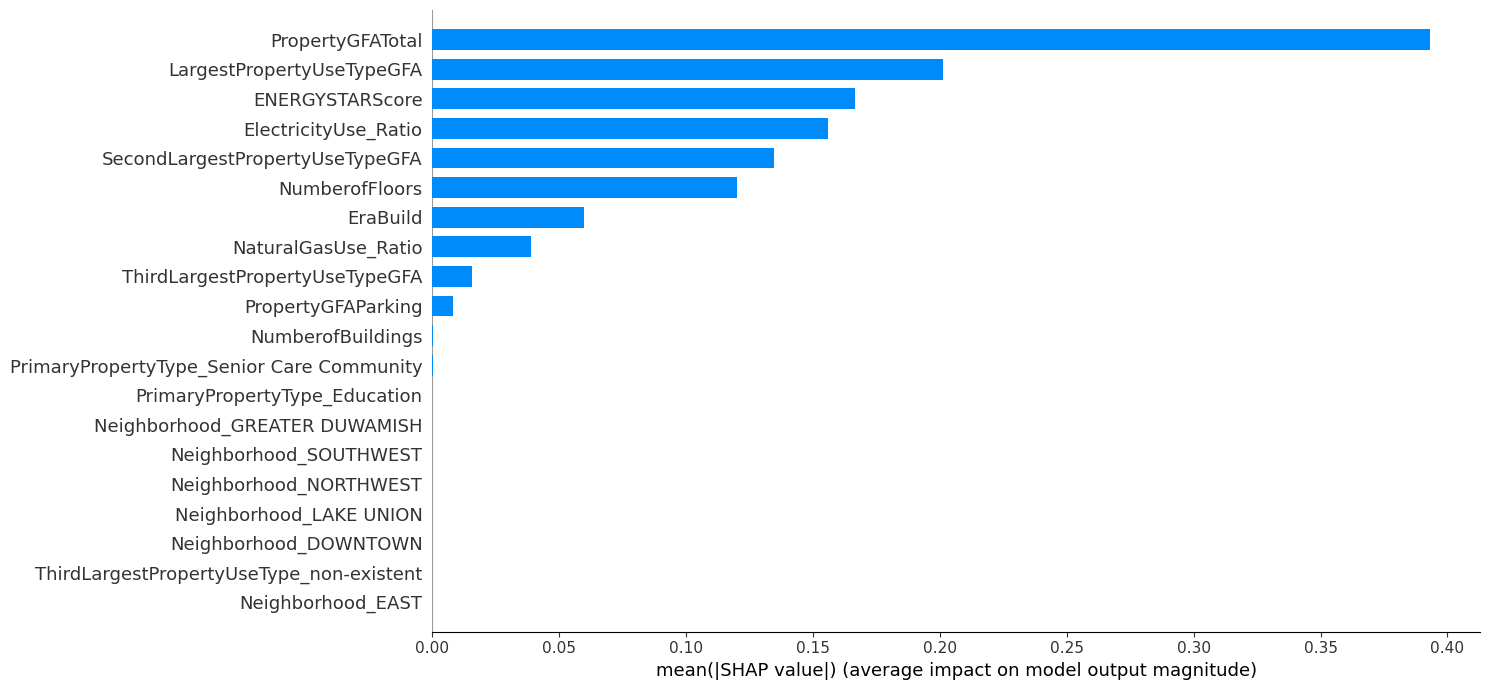

In [74]:
# Affichez le graphique d'importance des caractéristiques
shap.summary_plot(shap_values, 
                  X_energy_test_preprocessed, 
                  plot_type="bar", 
                  feature_names = column_names, 
                  plot_size=(15,7))

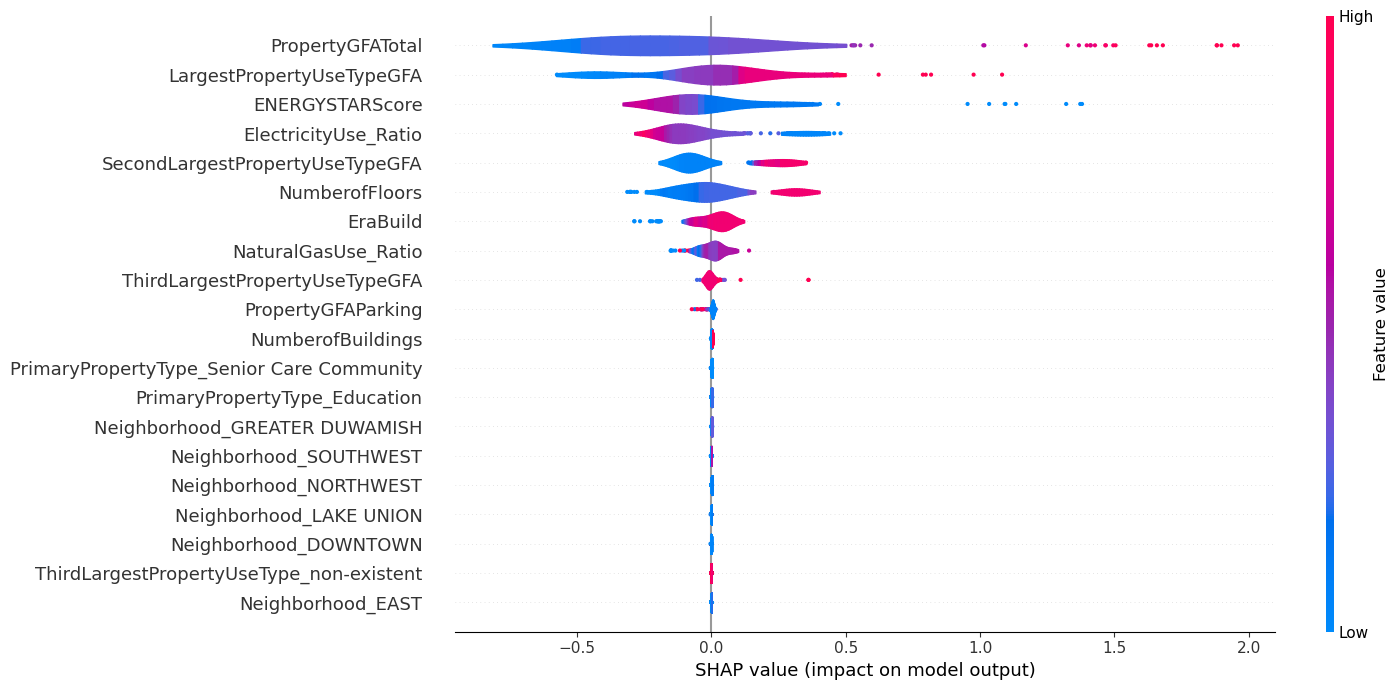

In [75]:
# Affichez le graphique d'importance des caractéristiques
shap.summary_plot(shap_values, 
                  X_energy_test_preprocessed, 
                  plot_type="violin", 
                  feature_names = column_names, 
                  plot_size=(15,7))

Ici on peut voir que lorsque la surface du bâtiment est élevée alors il y a un impact positif sur le modèle.

Donc plus le bâtiment est grand et plus il consomme de l'énergie.

## 7. Enregistrement du modèle <a class="anchor" id="7"></a>

In [76]:
# Sauvegarder le modèle XGBoost entraîné avec l'ENERGY STAR Score dans un fichier pickle
with open('Prediction_consommation_totale.pickle', 'wb') as file:
    pickle.dump(xgboost_ENERGY.best_estimator_, file)